# Email Spam Detection: Graph-Based Exploratory Data Analysis

**Goal**: Understand what graph features characterize spam emails and visualize spammer behavior in the email network.

**Key Questions**:
1. How do spammers behave differently in the network?
2. What graph features distinguish spam from legitimate emails?
3. How are spammers distributed and connected?
4. Can we identify spam communities?

## 1. Setup & Data Loading

In [110]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import tqdm as tqdm
from tqdm import tqdm
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [111]:
df = pd.read_csv("../../data/processed/graph_merge.csv")
print(f"Dataset loaded: {len(df):,} emails")
print(f"\ Columns: {df.columns.tolist()}")
print(f"\ Label distribution:")
print(df['label'].value_counts())
print(f"\nSpam rate: {df['label'].mean()*100:.1f}%")

Dataset loaded: 49,529 emails
\ Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
\ Label distribution:
label
1    28126
0    21403
Name: count, dtype: int64

Spam rate: 56.8%


## 2. Build Email Network Graph

We create a directed graph where:
- **Nodes** = Email addresses (senders and receivers)
- **Edges** = Email communications (sender → receiver)
- **Edge attributes** = spam_count, ham_count, weight

In [112]:
# Clean data
df = df.dropna(subset=['sender', 'receiver'])
df['sender'] = df['sender'].astype(str).str.strip().str.lower()
df['receiver'] = df['receiver'].astype(str).str.strip().str.lower()
df = df[(df['sender'] != 'nan') & (df['receiver'] != 'nan')]

print(f"After cleaning: {len(df):,} emails")

# Build directed graph
G = nx.DiGraph()

for idx, row in df.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
        G[sender][receiver]['ham_count'] += (1 - is_spam)
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"\n{'='*60}")
print(f" GRAPH STATISTICS:")
print(f"{'='*60}")
print(f"  Nodes (unique emails):     {G.number_of_nodes():,}")
print(f"  Edges (connections):       {G.number_of_edges():,}")
print(f"  Network density:           {nx.density(G):.6f}")
print(f"  Avg degree:                {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

After cleaning: 49,529 emails

 GRAPH STATISTICS:
  Nodes (unique emails):     37,670
  Edges (connections):       37,171
  Network density:           0.000026
  Avg degree:                1.97


In [113]:
# Extract basic features
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())
sender_features = []

# Group by sender for efficiency
for sender, group in df.groupby('sender'):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:  # Skip non-senders
        continue
    
    in_deg = in_degrees.get(sender, 0)
    
    # Basic metrics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    
    # Reciprocity: How many recipients replied back?
    receivers = list(G.successors(sender))
    reciprocity = sum([1 for r in receivers if G.has_edge(r, sender)]) / len(receivers) if receivers else 0
    
    sender_features.append({
        'sender': sender,
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': out_deg + in_deg,
        'total_sent': total_sent,
        'reciprocity': reciprocity,
        'is_spammer': 1 if spam_sent / total_sent > 0.8 else 0  # still use for labeling only
    })

features_df = pd.DataFrame(sender_features)

## 3. Get Basic Features

In [114]:
# ============================================================================
# BASIC FEATURE EXTRACTION
# ============================================================================

print("\n[1/1] Extracting basic features from graph...")

# Extract basic graph metrics
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())
sender_features = []

# Group by sender for efficiency
for sender, group in df.groupby('sender'):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:  # Skip non-senders
        continue
    
    in_deg = in_degrees.get(sender, 0)
    
    # Email statistics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    
    # Reciprocity: How many recipients have mutual connections?
    unique_receivers = set(group['receiver'])
    mutual_count = sum(1 for receiver in unique_receivers if G.has_edge(receiver, sender))
    reciprocity = mutual_count / len(unique_receivers) if unique_receivers else 0
    
    sender_features.append({
        'sender': sender,
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': out_deg + in_deg,
        'total_sent': total_sent,
        'reciprocity': reciprocity,
        'is_spammer': 1 if spam_sent / total_sent > 0.8 else 0
    })

features_df = pd.DataFrame(sender_features)

print(f"✓ Basic features extracted for {len(features_df):,} senders\n")


[1/1] Extracting basic features from graph...
✓ Basic features extracted for 31,398 senders



In [115]:
# Count spammers who have received emails from their recipients
spammer_reciprocity_count = 0
total_spammers = 0

for sender, group in df.groupby('sender'):
    if sender not in G:
        continue
    
    # Check if this sender is a spammer
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent if total_sent > 0 else 0
    
    if spam_ratio > 0.8:  # Using your spammer threshold
        total_spammers += 1
        
        # Check if this spammer has received any emails from their recipients
        unique_receivers = set(group['receiver'])
        has_reciprocal = any(G.has_edge(receiver, sender) for receiver in unique_receivers)
        
        if has_reciprocal:
            spammer_reciprocity_count += 1

print(f"Total spammers in dataset: {total_spammers}")
print(f"Spammers who received emails from recipients: {spammer_reciprocity_count}")
print(f"Percentage: {spammer_reciprocity_count/total_spammers*100:.2f}%")

# Additional analysis: Show some examples
print(f"\n{'─'*50}")
print("EXAMPLES OF SPAMMERS WITH RECIPROCAL CONNECTIONS:")
print(f"{'─'*50}")

count = 0
for sender, group in df.groupby('sender'):
    if count >= 5:  # Show first 5 examples
        break
        
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent if total_sent > 0 else 0
    
    if spam_ratio > 0.8 and sender in G:
        unique_receivers = set(group['receiver'])
        reciprocal_receivers = [r for r in unique_receivers if G.has_edge(r, sender)]
        
        if reciprocal_receivers:
            print(f"Spammer: {sender}")
            print(f"  - Sent {total_sent} emails ({spam_sent} were spam)")
            print(f"  - Has reciprocal connections with: {reciprocal_receivers}")
            print()
            count += 1

Total spammers in dataset: 26671
Spammers who received emails from recipients: 218
Percentage: 0.82%

──────────────────────────────────────────────────
EXAMPLES OF SPAMMERS WITH RECIPROCAL CONNECTIONS:
──────────────────────────────────────────────────
Spammer: "bellamy, jennifer" <jbellamy@cheo.on.ca>
  - Sent 1 emails (1 were spam)
  - Has reciprocal connections with: ['"bellamy, jennifer" <jbellamy@cheo.on.ca>']

Spammer: "cabuay, ben m (dpa)" <ben.cabuay@ky.gov>
  - Sent 1 emails (1 were spam)
  - Has reciprocal connections with: ['"cabuay, ben m (dpa)" <ben.cabuay@ky.gov>']

Spammer: "chisanga, erica (consultant nurse - epilepsies)"
	<erica.chisanga@addenbrookes.nhs.uk>
  - Sent 1 emails (1 were spam)
  - Has reciprocal connections with: ['"chisanga, erica (consultant nurse - epilepsies)"\n\t<erica.chisanga@addenbrookes.nhs.uk>']

Spammer: "cleyn, tricia" <tcleyn@cheo.on.ca>
  - Sent 1 emails (1 were spam)
  - Has reciprocal connections with: ['"cleyn, tricia" <tcleyn@cheo.on.ca>

In [116]:
# ============================================================================
# ADVANCED FEATURE EXTRACTION (Additional Features)
# ============================================================================

print("[1/3] Computing clustering coefficient...")
clustering = nx.clustering(G.to_undirected())

print("[2/3] Computing closeness and eigenvector centrality...")
closeness = nx.closeness_centrality(G)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=100)
except:
    print("   Warning: Eigenvector centrality failed, using zeros")
    eigenvector = {node: 0 for node in G.nodes()}

print("[3/3] Computing triangles...")
G_clean = G.copy()
G_clean.remove_edges_from(nx.selfloop_edges(G_clean))
triangles = nx.triangles(G_clean.to_undirected())

print("✓ All graph features computed!\n")

# Add advanced features to existing dataframe
features_df['clustering'] = features_df['sender'].map(lambda x: clustering.get(x, 0))
features_df['eigenvector'] = features_df['sender'].map(lambda x: eigenvector.get(x, 0))
features_df['closeness'] = features_df['sender'].map(lambda x: closeness.get(x, 0))
features_df['triangles'] = features_df['sender'].map(lambda x: triangles.get(x, 0))

# Add average weight
features_df['avg_weight'] = features_df['sender'].map(
    lambda s: np.mean([G[s][r]['weight'] for r in G.successors(s)]) if list(G.successors(s)) else 0
)

print("="*70)
print(" FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"Total features: {len(features_df.columns)}")
print(f"Senders analyzed: {len(features_df):,}")
print(f"Spammers: {features_df['is_spammer'].sum():,}")
print(f"Legitimate: {(features_df['is_spammer'] == 0).sum():,}")

# ============================================================================
# FEATURES COMPARISON: SPAMMER vs LEGITIMATE
# ============================================================================
print(f"\n{'='*80}")
print(f" FEATURES COMPARISON: SPAMMER vs LEGITIMATE")
print(f"{'='*80}\n")

all_features = [
    'out_degree', 'in_degree', 'total_degree', 'total_sent', 'reciprocity',
    'clustering', 'avg_weight', 'eigenvector', 'closeness', 'triangles'
]

spam_users = features_df[features_df['is_spammer'] == 1]
legit_users = features_df[features_df['is_spammer'] == 0]

comparison_rows = []
for feature in all_features:
    spam_mean = spam_users[feature].mean()
    legit_mean = legit_users[feature].mean()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    comparison_rows.append([
        feature,
        f"{spam_mean:.6f}",
        f"{legit_mean:.6f}",
        f"{ratio:.3f}x",
        "🔴 Spam higher" if ratio > 1.2 else ("🟢 Legit higher" if ratio < 0.8 else "⚪ Similar")
    ])

comparison_df = pd.DataFrame(comparison_rows, columns=[
    'Feature', 'Spam Mean', 'Legit Mean', 'Ratio', 'Interpretation'
])

print(comparison_df.to_string(index=False))

# Find top discriminative features
print(f"\n{'─'*80}")
print(f" TOP DISCRIMINATIVE FEATURES:")
print(f"{'─'*80}")

comparison_df['abs_diff'] = abs(comparison_df['Ratio'].str.replace('x', '').astype(float) - 1.0)
top_features = comparison_df.nlargest(len(all_features), 'abs_diff')
print(top_features[['Feature', 'Spam Mean', 'Legit Mean', 'Ratio', 'Interpretation']].to_string(index=False))

print(f"\n{'─'*80}")
print(f" KEY INSIGHTS:")
print(f"{'─'*80}")

for idx, row in top_features.head(3).iterrows():
    feature = row['Feature']
    interpretation = row['Interpretation']
    ratio = row['Ratio']
    print(f"  • {feature:20s}: {interpretation:20s} ({ratio})")

[1/3] Computing clustering coefficient...
[2/3] Computing closeness and eigenvector centrality...
[3/3] Computing triangles...
✓ All graph features computed!

 FEATURE EXTRACTION COMPLETE
Total features: 12
Senders analyzed: 31,398
Spammers: 26,671
Legitimate: 4,727

 FEATURES COMPARISON: SPAMMER vs LEGITIMATE

     Feature Spam Mean Legit Mean  Ratio Interpretation
  out_degree  1.041356   1.987942 0.524x 🟢 Legit higher
   in_degree  0.270219   0.986038 0.274x 🟢 Legit higher
total_degree  1.311574   2.973979 0.441x 🟢 Legit higher
  total_sent  1.054329   4.529088 0.233x 🟢 Legit higher
 reciprocity  0.008155   0.036067 0.226x 🟢 Legit higher
  clustering  0.000160   0.063267 0.003x 🟢 Legit higher
  avg_weight  1.008846   2.471576 0.408x 🟢 Legit higher
 eigenvector  0.000000   0.001671 0.000x 🟢 Legit higher
   closeness  0.000007   0.000694 0.010x 🟢 Legit higher
   triangles  0.002775   1.466469 0.002x 🟢 Legit higher

──────────────────────────────────────────────────────────────────────

## 6.  Comprehensive Visualization Dashboard

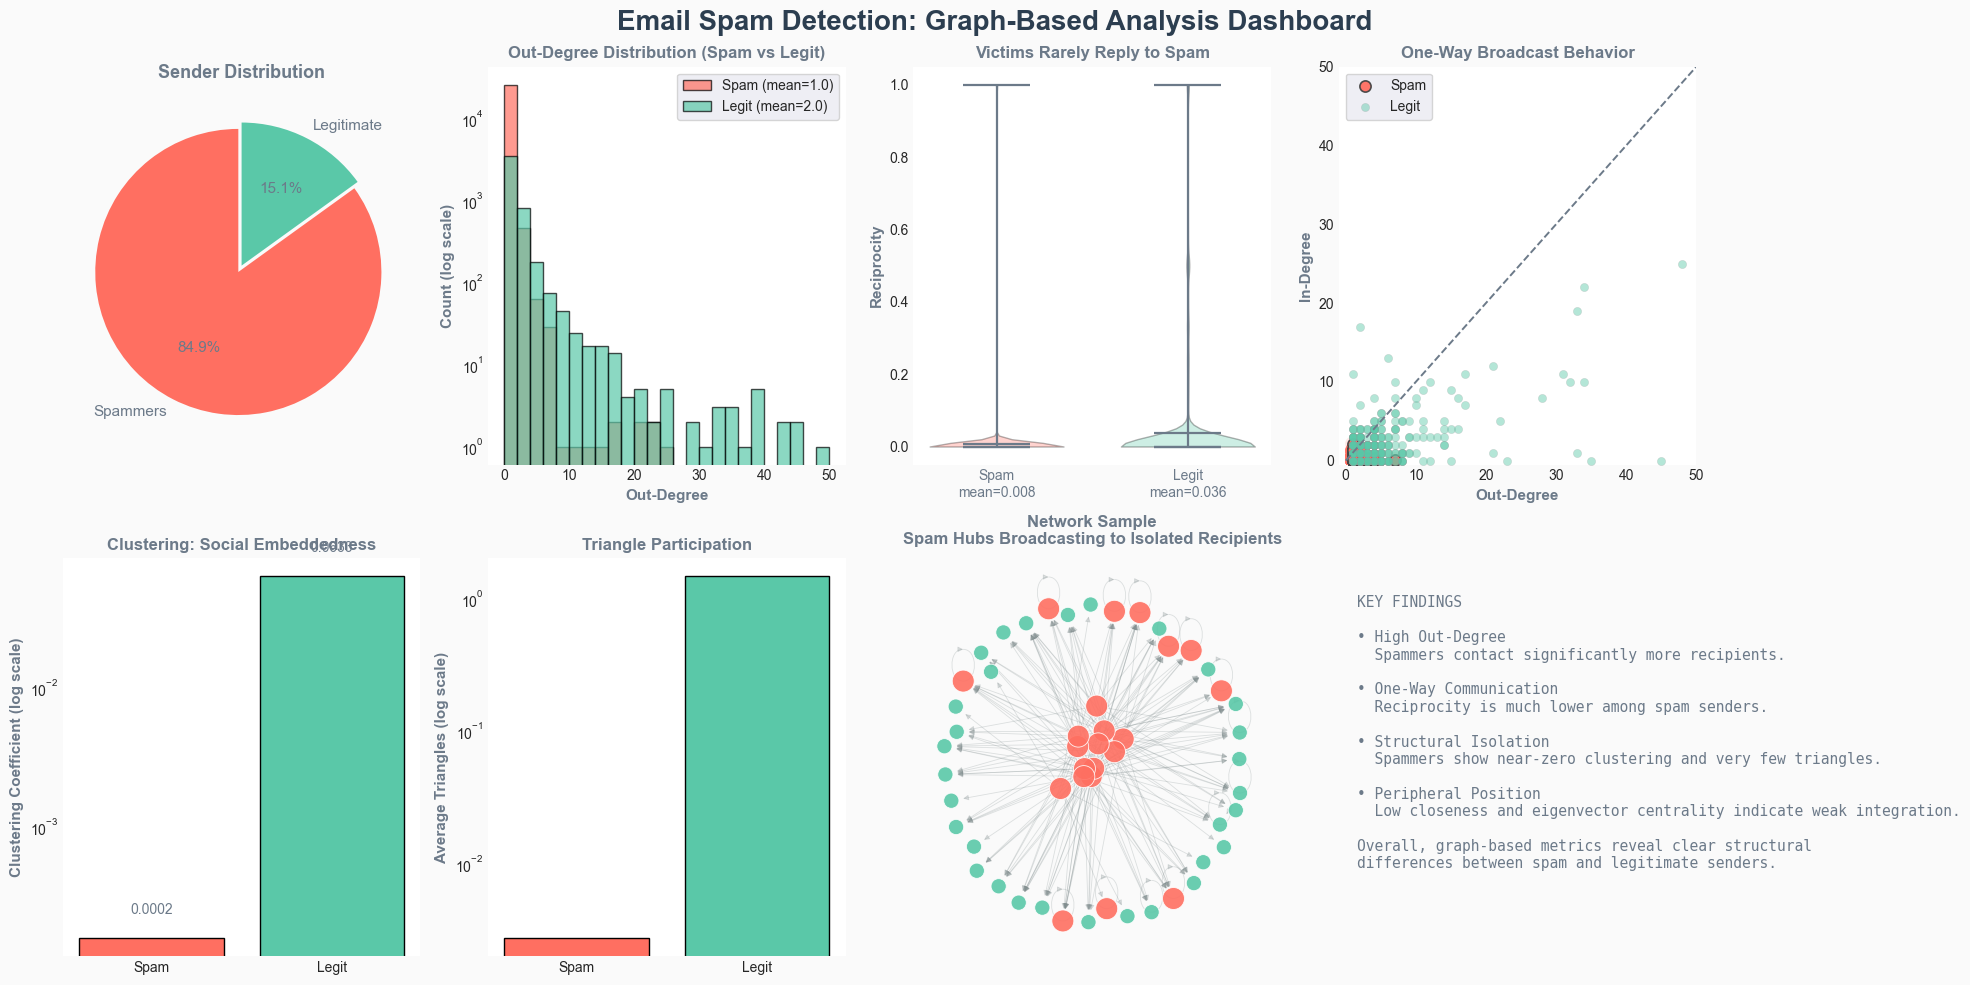

In [126]:
# ============================================================================
# VISUALIZATION DASHBOARD (Academic Style, No Emojis)
# ============================================================================

# Create dashboard
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('#FAFAFA')
fig.suptitle('Email Spam Detection: Graph-Based Analysis Dashboard', 
             fontsize=20, fontweight='bold', y=0.98, color='#2C3E50')

# Convenience subsets
spam_df = features_df[features_df['is_spammer'] == 1]
legit_df = features_df[features_df['is_spammer'] == 0]

spam_color  = '#FF6F61'   # Living Coral
legit_color = '#5AC8A8'   # Soft Aqua
accent_color = '#6C7A89'  # Modern Grey


# ============================================================================
# Panel 1: Sender Distribution
# ============================================================================
ax1 = plt.subplot(2, 4, 1)
ax1.set_facecolor('white')

sender_counts = [len(spam_df), len(legit_df)]
colors = [spam_color, legit_color]
labels = ['Spammers', 'Legitimate']

wedges, texts, autotexts = ax1.pie(
    sender_counts, labels=labels, colors=colors,
    autopct='%1.1f%%', startangle=90, explode=(0.05, 0),
    textprops={'fontsize': 11, 'color': accent_color}
)

ax1.set_title('Sender Distribution', fontweight='bold', fontsize=13, color=accent_color)

# ============================================================================
# Panel 2: Out-Degree Distribution
# ============================================================================
ax2 = plt.subplot(2, 4, 2)
ax2.set_facecolor('white')

bins = np.linspace(0, 50, 26)

ax2.hist(spam_df['out_degree'], bins=bins, alpha=0.70, color=spam_color, 
         label=f"Spam (mean={spam_df['out_degree'].mean():.1f})", edgecolor='black')
ax2.hist(legit_df['out_degree'], bins=bins, alpha=0.70, color=legit_color, 
         label=f"Legit (mean={legit_df['out_degree'].mean():.1f})", edgecolor='black')

ax2.set_xlabel('Out-Degree', fontsize=11, fontweight='bold', color=accent_color)
ax2.set_ylabel('Count (log scale)', fontsize=11, fontweight='bold', color=accent_color)
ax2.set_yscale('log')
ax2.set_title('Out-Degree Distribution (Spam vs Legit)', fontweight='bold', fontsize=12, color=accent_color)
ax2.grid(alpha=0.25, linestyle='--', linewidth=0.5)
ax2.legend(frameon=True)

# ============================================================================
# Panel 3: Reciprocity Comparison (Violin)
# ============================================================================
ax3 = plt.subplot(2, 4, 3)
ax3.set_facecolor('white')

data_recip = [spam_df['reciprocity'], legit_df['reciprocity']]

parts = ax3.violinplot(
    data_recip, positions=[1, 2], widths=0.7,
    showmeans=True, showmedians=True
)

# Color violins
parts['bodies'][0].set_facecolor(spam_color);  parts['bodies'][0].set_edgecolor('black')
parts['bodies'][1].set_facecolor(legit_color); parts['bodies'][1].set_edgecolor('black')

# Line colors
for partname in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
    if partname in parts:
        parts[partname].set_edgecolor(accent_color)
        parts[partname].set_linewidth(1.6)

ax3.set_xticks([1, 2])
ax3.set_xticklabels(
    [f"Spam\nmean={spam_df['reciprocity'].mean():.3f}",
     f"Legit\nmean={legit_df['reciprocity'].mean():.3f}"],
    color=accent_color, fontsize=10
)
ax3.set_ylabel('Reciprocity', fontsize=11, fontweight='bold', color=accent_color)
ax3.set_title('Victims Rarely Reply to Spam', fontsize=12, fontweight='bold', color=accent_color)
ax3.grid(axis='y', alpha=0.25, linestyle='--')

# ============================================================================
# Panel 4: In-Degree vs Out-Degree (Improved Visibility + Highlight Spam)
# ============================================================================
ax4 = plt.subplot(2, 4, 4)
ax4.set_facecolor('white')

# Sampling
n_sample = 2000
spam_sample = spam_df.sample(min(n_sample, len(spam_df)))
legit_sample = legit_df.sample(min(n_sample, len(legit_df)))

# Increase jitter so spam at y ≈ 0 becomes clearly visible
spam_y = spam_sample['in_degree'] + np.random.uniform(0.08, 0.35, len(spam_sample))
legit_y = legit_sample['in_degree']

# --- Glow / halo effect under spam points -----------------------------------
ax4.scatter(
    spam_sample['out_degree'], spam_y,
    s=120, alpha=0.15, color=spam_color,
    linewidths=0, edgecolors='none'
)

# --- Spam points (foreground) ------------------------------------------------
ax4.scatter(
    spam_sample['out_degree'], spam_y,
    c=spam_color,
    alpha=0.95,       # strong visibility
    s=65,             # bigger points
    linewidths=1.2, 
    edgecolors='#444444',   # dark grey outline
    label='Spam'
)

# --- Legit points (subtle) ---------------------------------------------------
ax4.scatter(
    legit_sample['out_degree'], legit_y,
    c=legit_color,
    alpha=0.45,       # more subtle so spam dominates
    s=35,
    linewidths=0.3,
    edgecolors='#999999',
    label='Legit'
)

# Reference diagonal (two-way)
max_val = 50
ax4.plot([0, max_val], [0, max_val],
         color=accent_color, linestyle='--', linewidth=1.4)

ax4.set_xlabel('Out-Degree', fontsize=11, fontweight='bold', color=accent_color)
ax4.set_ylabel('In-Degree', fontsize=11, fontweight='bold', color=accent_color)
ax4.set_title('One-Way Broadcast Behavior', fontsize=12, fontweight='bold', color=accent_color)

ax4.set_xlim(-1, max_val)
ax4.set_ylim(-0.5, max_val)

ax4.legend(frameon=True)
ax4.grid(alpha=0.25, linestyle='--')



# ============================================================================
# Panel 5: Clustering Coefficient
# ============================================================================
ax5 = plt.subplot(2, 4, 5)
ax5.set_facecolor('white')

clust_means = [
    spam_df['clustering'].mean(),
    legit_df['clustering'].mean()
]

bars = ax5.bar(['Spam', 'Legit'], clust_means,
               color=[spam_color, legit_color], edgecolor='black')

ax5.set_ylabel('Clustering Coefficient (log scale)', fontsize=11, fontweight='bold', color=accent_color)
ax5.set_yscale('log')
ax5.set_title('Clustering: Social Embeddedness', fontweight='bold', fontsize=12, color=accent_color)
ax5.grid(axis='y', linestyle='--', alpha=0.25)

# Labels
for bar in bars:
    ax5.text(
        bar.get_x() + bar.get_width()/2., bar.get_height()*1.5,
        f"{bar.get_height():.4f}",
        ha='center', fontsize=10, color=accent_color
    )

# ============================================================================
# Panel 6: Triangles
# ============================================================================
ax6 = plt.subplot(2, 4, 6)
ax6.set_facecolor('white')

tri_means = [
    spam_df['triangles'].mean(),
    legit_df['triangles'].mean()
]

bars = ax6.bar(['Spam', 'Legit'], [tri_means[0] + 1e-6, tri_means[1]],
               color=[spam_color, legit_color], edgecolor='black')

ax6.set_ylabel('Average Triangles (log scale)', fontsize=11, fontweight='bold', color=accent_color)
ax6.set_yscale('log')
ax6.set_title('Triangle Participation', fontweight='bold', fontsize=12, color=accent_color)
ax6.grid(axis='y', linestyle='--', alpha=0.25)

# ============================================================================
# Panel 7 (REPLACEMENT): Network Visualization – Spam Hub Structure
# ============================================================================

ax7 = plt.subplot(2, 4, 7)
ax7.set_facecolor('white')
ax7.set_title('Network Sample\nSpam Hubs Broadcasting to Isolated Recipients',
              fontsize=12, fontweight='bold', color=accent_color, pad=10)

# --- Select top spam hubs ---------------------------------------------------
top_spammers = (
    spam_df.nlargest(12, 'out_degree')['sender'].tolist()
)

# Gather their receivers (limited for clarity)
sample_nodes = set(top_spammers)
for s in top_spammers:
    receivers = list(G.successors(s))[:8]      # limit to avoid clutter
    sample_nodes.update(receivers)

# Extract subgraph
subG = G.subgraph(list(sample_nodes))

# Graph layout
pos = nx.spring_layout(subG, k=0.85, iterations=100, seed=42)

# Color based on spam / legit
node_colors = [
    spam_color if n in spam_df['sender'].values else legit_color
    for n in subG.nodes()
]

node_sizes = [
    250 if n in spam_df['sender'].values else 120
    for n in subG.nodes()
]

# Draw edges
nx.draw_networkx_edges(
    subG, pos,
    ax=ax7,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=8,
    alpha=0.25,
    width=0.6,
    edge_color='#7f8c8d'
)

# Draw nodes
nx.draw_networkx_nodes(
    subG, pos,
    ax=ax7,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    linewidths=0.6,
    edgecolors='white'
)

# Remove axes
ax7.axis('off')


# ============================================================================
# Panel 8: Key Insights (Text Panel)
# ============================================================================
ax8 = plt.subplot(2, 4, 8)
ax8.axis('off')
ax8.set_facecolor('white')

insights_text = f"""
KEY FINDINGS

• High Out-Degree  
  Spammers contact significantly more recipients.

• One-Way Communication  
  Reciprocity is much lower among spam senders.

• Structural Isolation  
  Spammers show near-zero clustering and very few triangles.

• Peripheral Position  
  Low closeness and eigenvector centrality indicate weak integration.

Overall, graph-based metrics reveal clear structural
differences between spam and legitimate senders.
"""

ax8.text(
    0.05, 0.95, insights_text,
    fontsize=10.5, fontfamily='monospace',
    color=accent_color, va='top'
)

# ============================================================================
plt.tight_layout()
#plt.savefig('spam_eda_dashboard.png', dpi=300, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()


## 7.  Network Structure Analysis

Analyze how spammers connect to each other vs how legitimate users interact.

In [118]:
spam_to_spam = []
spam_to_non = []
non_to_spam = []
non_to_non = []

for u, v, data in G.edges(data=True):
    sender_spam = u in spammers
    receiver_spam = v in spammers
    
    if sender_spam and receiver_spam:
        spam_to_spam.append((u, v, data))
    elif sender_spam and not receiver_spam:
        spam_to_non.append((u, v, data))
    elif not sender_spam and receiver_spam:
        non_to_spam.append((u, v, data))
    else:  # neither is spam
        non_to_non.append((u, v, data))

total_edges = G.number_of_edges()

print(f"\nEdge Classification:")
print(f"{'─'*70}")
print(f"🔴 Spam → Spam:     {len(spam_to_spam):6,} ({len(spam_to_spam)/total_edges*100:5.1f}%)")
print(f"🔴 Spam → Non-Spam: {len(spam_to_non):6,} ({len(spam_to_non)/total_edges*100:5.1f}%)")
print(f"🟢 Non-Spam → Spam: {len(non_to_spam):6,} ({len(non_to_spam)/total_edges*100:5.1f}%)")
print(f"🟢 Non-Spam → Non-Spam: {len(non_to_non):6,} ({len(non_to_non)/total_edges*100:5.1f}%)")

print(f"\n{'='*70}")
print("💡 KEY INSIGHTS:")
print(f"{'='*70}")
print(f"""
1. Spam cluster: {len(spam_to_spam)} internal spam links
   → Indicates bot clusters or coordinated spam rings

2. Spam broadcast behavior: {len(spam_to_non)} spam → non-spam links
   → Primary spam attack vector

3. Low reply rates: {len(non_to_spam)} non-spam → spam responses
   → Real users rarely reply to spam

4. Normal communication: {len(non_to_non)} non-spam → non-spam links
   → Represents authentic social network email flow
""")
print("="*70)




Edge Classification:
──────────────────────────────────────────────────────────────────────
🔴 Spam → Spam:         37 (  0.1%)
🔴 Spam → Non-Spam: 27,520 ( 74.0%)
🟢 Non-Spam → Spam:      6 (  0.0%)
🟢 Non-Spam → Non-Spam:  9,608 ( 25.8%)

💡 KEY INSIGHTS:

1. Spam cluster: 37 internal spam links
   → Indicates bot clusters or coordinated spam rings

2. Spam broadcast behavior: 27520 spam → non-spam links
   → Primary spam attack vector

3. Low reply rates: 6 non-spam → spam responses
   → Real users rarely reply to spam

4. Normal communication: 9608 non-spam → non-spam links
   → Represents authentic social network email flow



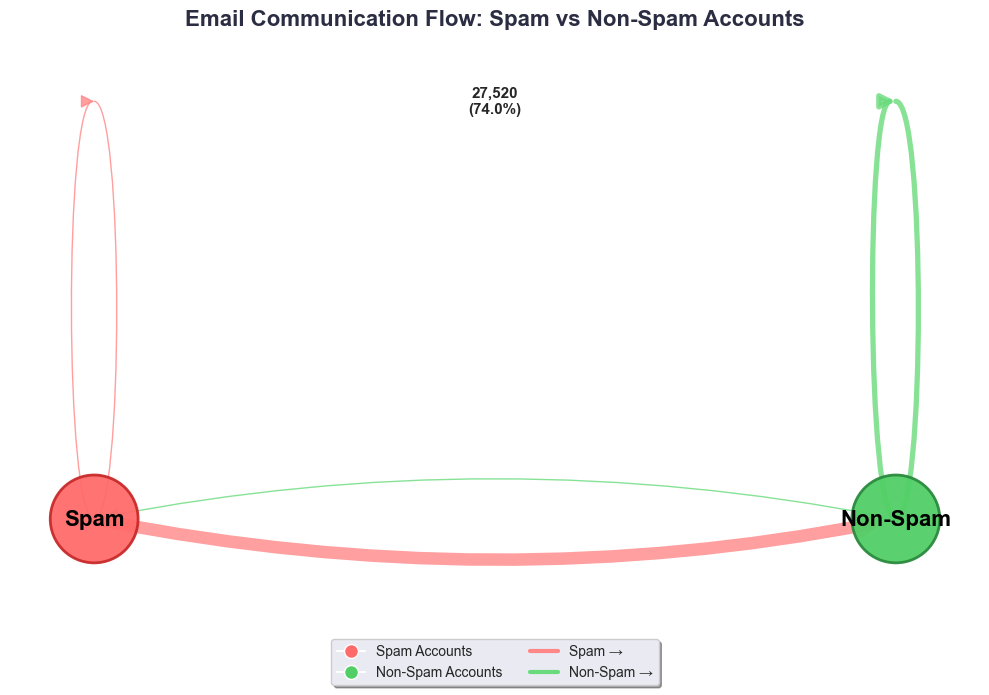


FLOW SUMMARY STATISTICS
Spam → Spam:       37 emails (0.1%)
Spam → Non-Spam:   27,520 emails (74.0%)
Non-Spam → Spam:   6 emails (0.0%)
Non-Spam → Non-Spam: 9,608 emails (25.8%)
Total emails:      37,171


In [119]:
# ============================================================================
# Figure: Two-Node Flow Graph (Spam ↔ Non-Spam) - Clean Version
# ============================================================================

import matplotlib.pyplot as plt
import networkx as nx

# Build a simple 2-node directed graph
H = nx.DiGraph()

H.add_node("Spam", color='#ff6b6b')      # Soft red for spam
H.add_node("Non-Spam", color='#51cf66')  # Soft green for non-spam

# Add weighted edges
H.add_edge("Spam", "Spam", weight=len(spam_to_spam))
H.add_edge("Spam", "Non-Spam", weight=len(spam_to_non))
H.add_edge("Non-Spam", "Spam", weight=len(non_to_spam))
H.add_edge("Non-Spam", "Non-Spam", weight=len(non_to_non))

# Calculate percentages for labels
total_emails = len(spam_to_spam) + len(spam_to_non) + len(non_to_spam) + len(non_to_non)
spam_to_spam_pct = (len(spam_to_spam) / total_emails) * 100
spam_to_non_pct = (len(spam_to_non) / total_emails) * 100
non_to_spam_pct = (len(non_to_spam) / total_emails) * 100
non_to_non_pct = (len(non_to_non) / total_emails) * 100

# Normalize edge thickness
max_w = max(len(spam_to_spam), len(spam_to_non), len(non_to_spam), len(non_to_non))
def scale(w): return 1 + (w / max_w) * 8   # More subtle thickness

pos = {
    "Spam": (-1, 0),
    "Non-Spam": (1, 0)
}

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor('#f8f9fa')

# Draw nodes with better styling
nx.draw_networkx_nodes(
    H, pos,
    node_color=['#ff6b6b', '#51cf66'],
    node_size=4000,
    alpha=0.95,
    linewidths=2,
    edgecolors=['#c92a2a', '#2b8a3e']
)

# Draw labels with better styling
nx.draw_networkx_labels(
    H, pos,
    font_size=16, 
    font_weight='bold',
    font_family='sans-serif'
)

# Draw edges with better styling
edge_colors = {
    ("Spam", "Spam"): '#ff8787',
    ("Spam", "Non-Spam"): '#ff8787', 
    ("Non-Spam", "Spam"): '#69db7c',
    ("Non-Spam", "Non-Spam"): '#69db7c'
}

# Draw edges
for (u, v, data) in H.edges(data=True):
    nx.draw_networkx_edges(
        H, pos,
        edgelist=[(u, v)],
        arrowstyle='-|>',
        arrowsize=20,
        width=scale(data['weight']),
        edge_color=edge_colors[(u, v)],
        alpha=0.8,
        connectionstyle='arc3,rad=0.25' if u == v else 'arc3,rad=0.1'
    )

# Add edge labels with counts and percentages
edge_labels = {
    ("Spam", "Spam"): f"{len(spam_to_spam):,}\n({spam_to_spam_pct:.1f}%)",
    ("Spam", "Non-Spam"): f"{len(spam_to_non):,}\n({spam_to_non_pct:.1f}%)",
    ("Non-Spam", "Spam"): f"{len(non_to_spam):,}\n({non_to_spam_pct:.1f}%)", 
    ("Non-Spam", "Non-Spam"): f"{len(non_to_non):,}\n({non_to_non_pct:.1f}%)"
}

# Position edge labels nicely
label_pos = {
    ("Spam", "Spam"): (-1.3, 0.3),
    ("Spam", "Non-Spam"): (0, 0.15),
    ("Non-Spam", "Spam"): (0, -0.15),
    ("Non-Spam", "Non-Spam"): (1.3, 0.3)
}

for edge, label in edge_labels.items():
    plt.annotate(label, 
                xy=label_pos[edge], 
                xytext=label_pos[edge],
                ha='center', va='center',
                fontsize=11,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'),
                fontweight='bold')

plt.title("Email Communication Flow: Spam vs Non-Spam Accounts", 
          fontsize=16, fontweight='bold', pad=20, color='#2b2d42')
plt.axis('off')
plt.tight_layout()

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff6b6b', markersize=10, label='Spam Accounts'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#51cf66', markersize=10, label='Non-Spam Accounts'),
    plt.Line2D([0], [0], color='#ff8787', lw=3, label='Spam →'),
    plt.Line2D([0], [0], color='#69db7c', lw=3, label='Non-Spam →')
]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           ncol=2, frameon=True, fancybox=True, shadow=True)

plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("FLOW SUMMARY STATISTICS")
print(f"{'='*60}")
print(f"Spam → Spam:       {len(spam_to_spam):,} emails ({spam_to_spam_pct:.1f}%)")
print(f"Spam → Non-Spam:   {len(spam_to_non):,} emails ({spam_to_non_pct:.1f}%)") 
print(f"Non-Spam → Spam:   {len(non_to_spam):,} emails ({non_to_spam_pct:.1f}%)")
print(f"Non-Spam → Non-Spam: {len(non_to_non):,} emails ({non_to_non_pct:.1f}%)")
print(f"{'='*60}")
print(f"Total emails:      {total_emails:,}")

In [121]:
features_df.columns

Index(['sender', 'out_degree', 'in_degree', 'total_degree', 'total_sent',
       'reciprocity', 'is_spammer', 'clustering', 'eigenvector', 'closeness',
       'triangles', 'avg_weight'],
      dtype='object')